In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from preprocess import prepare_df

In [5]:
df = pd.read_excel("Imdb.xlsx")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
sentiment_counts = df["sentiment"].value_counts()

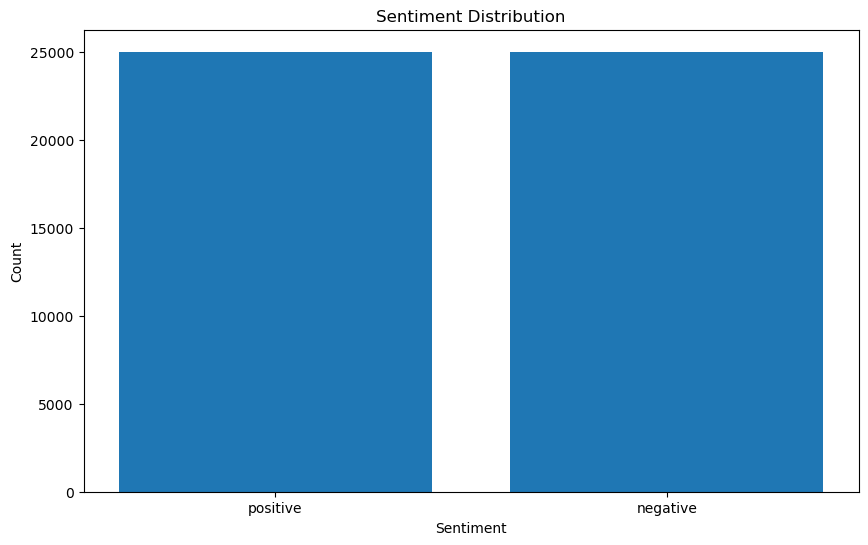

In [8]:
plt.figure(figsize=(10,6))
plt.bar(sentiment_counts.index,sentiment_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

#### From initial exploration it's clear thhat there is no null values and the dataset is unbiased

In [14]:
df = prepare_df(df)
df

,review,sentiment,cleaned_text,word_count,review_length
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode hoo...,168,1090
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...,86,622
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...,84,552
3,Basically there's a family where a little boy ...,negative,basically family little boy jake think zombie ...,67,426
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...,127,831
...,...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,thought movie right good job creative original...,81,505
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...,56,372
49997,I am a Catholic taught in parochial elementary...,negative,catholic taught parochial elementary school nu...,116,790
49998,I'm going to have to disagree with the previou...,negative,going disagree previous comment side maltin on...,112,808


## Model Building

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix
from sklearn.pipeline import make_pipeline

In [27]:
X = df[['cleaned_text', 'word_count', 'review_length']]
y = df['sentiment']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,
X_test.shape,
y_train.shape,
y_test.shape)

(40000, 3) (10000, 3) (40000,) (10000,)


In [31]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000), 'cleaned_text'),
        ('num', StandardScaler(), ['word_count', 'review_length'])
    ]
)

In [33]:
model = make_pipeline(
    preprocessor,
    LogisticRegression()
)

In [35]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'cleaned_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count',
                                                   'review_length'])])),
                ('logisticregression', LogisticRegression())])

In [37]:
y_pred_lr = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


Accuracy: 0.8851
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [39]:
# For ROC-AUC
y_test_binary = y_test.map({'negative': 0, 'positive': 1})
y_proba = model.predict_proba(X_test)[:, 1]
print("ROC-AUC Score:", roc_auc_score(y_test_binary, y_proba))

ROC-AUC Score: 0.9564470702397534



Confusion Matrix:
 [[4326  635]
 [ 499 4540]]


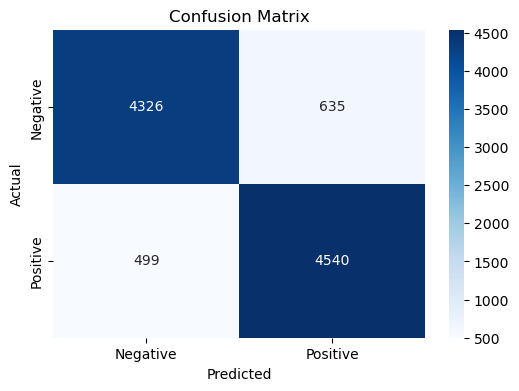

In [141]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr, labels=['negative', 'positive'])
print("\nConfusion Matrix:\n", conf_matrix_lr)
# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
from sklearn.svm import LinearSVC
model_svm = make_pipeline(
    preprocessor,
    LinearSVC()
)

In [43]:
model_svm.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'cleaned_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count',
                                                   'review_length'])])),
                ('linearsvc', LinearSVC())])

In [45]:
y_pred_svm = model_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

Accuracy: 0.8797
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [47]:
from sklearn.preprocessing import LabelBinarizer

# Get decision function scores instead of class labels
y_pred_scores = model_svm.decision_function(X_test)

# Convert y_test to binary (0/1) if it's categorical ('positive'/'negative')
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()

print("\nROC-AUC SCORE:",roc_auc_score(y_test,y_pred_scores))


ROC-AUC SCORE: 0.9519936392930146



Confusion Matrix:
 [[4307  654]
 [ 549 4490]]


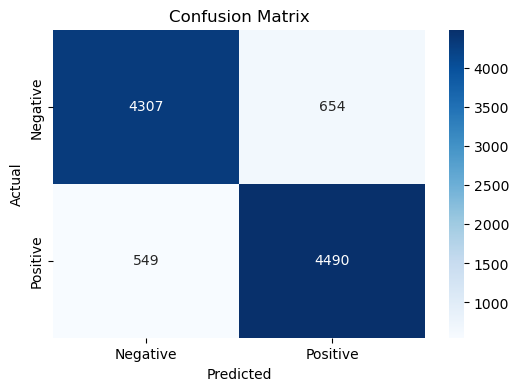

In [49]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("\nConfusion Matrix:\n", conf_matrix_svm)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
from sklearn.naive_bayes import MultinomialNB
model_nb = make_pipeline(
    preprocessor,
    MultinomialNB()
)

In [53]:
from sklearn.ensemble import RandomForestClassifier
model_rf = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, random_state=42)
)


In [55]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'cleaned_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count',
                                                   'review_length'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [57]:
y_pred_rf = model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.8478

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.86      0.85      4961
    positive       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



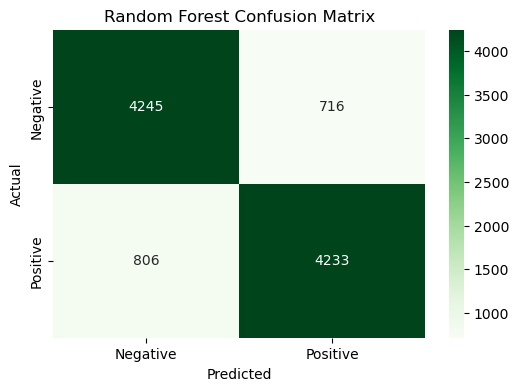

In [59]:
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

In [171]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
    'randomforestclassifier__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:")
print(grid_search.best_params_)

print("\nBest Cross-Validation Score:")
print(grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 200}

Best Cross-Validation Score:
0.8505


#### After hyperparam tuning for different models the logisticregression base model had the best evaluation metrics

In [61]:
import joblib
joblib.dump(model,"logisticregression.pkl")

['logisticregression.pkl']

## Insights

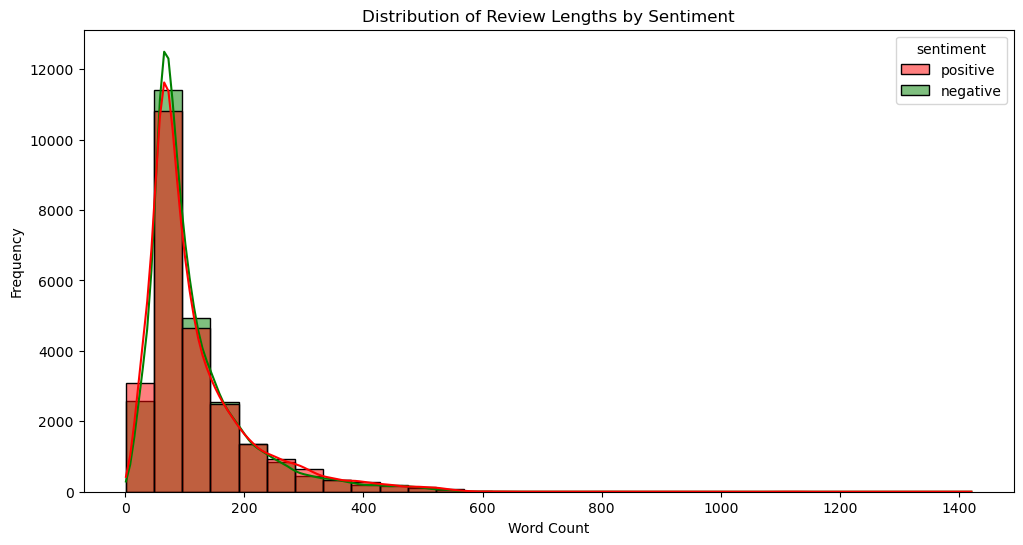

In [64]:
#Word Frequency: High frequency highlight important words that drive sentiment.
#Review Length: Longer reviews provide more context, while shorter reviews may lack detail.

# Histogram of review lengths
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=30, kde=True, palette=['red', 'green'])
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()



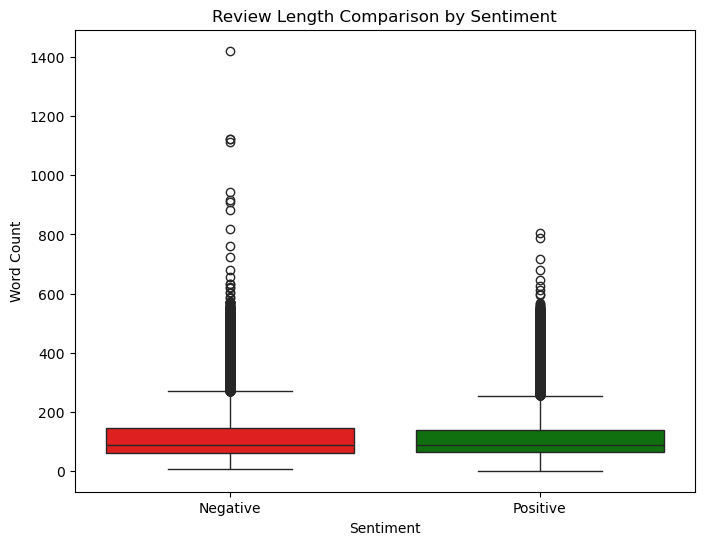

In [65]:
# Box plot comparing review lengths
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='sentiment', y='word_count', hue='sentiment', palette=['red', 'green'], legend=False)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title("Review Length Comparison by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Word Count")
plt.show()

In [66]:
best_model = joblib.load("logisticregression.pkl")
best_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=5000),
                                                  'cleaned_text'),
                                                 ('num', StandardScaler(),
                                                  ['word_count',
                                                   'review_length'])])),
                ('logisticregression', LogisticRegression())])

## Extracting Feature importances and plotting

In [71]:
tfidf = model.named_steps["columntransformer"].named_transformers_["text"]
scaler = model.named_steps["columntransformer"].named_transformers_["num"]

coefficients = model.named_steps["logisticregression"].coef_[0]

tfidf_feature_names = tfidf.get_feature_names_out()
numerical_features = ['word_count', 'review_length']
feature_names = list(tfidf_feature_names) + numerical_features

#Verify lengths
print("Length of feature_names:", len(feature_names))
print("Length of coefficients:", len(coefficients))

#Create DataFrame
if len(feature_names) == len(coefficients):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)

    print("Top Positive Features:")
    print(feature_importance.head(10))
else:
    print("Mismatch in feature lengths. Check your feature_names and coefficients.")

Length of feature_names: 5002
Length of coefficients: 5002
Top Positive Features:
        Feature  Coefficient
1946      great     6.977585
1535  excellent     6.717523
3221    perfect     5.077150
152     amazing     4.854500
4937  wonderful     4.844493
412        best     4.810488
1652   favorite     4.492747
531   brilliant     4.392663
2669      loved     4.333765
2095  hilarious     4.135709


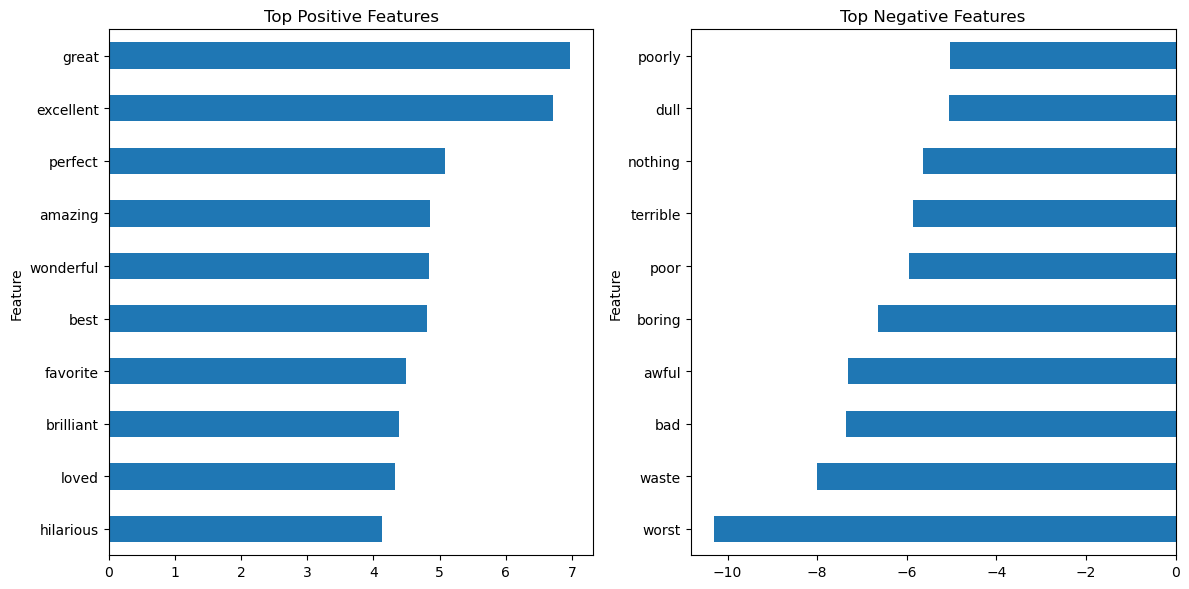

In [73]:
#top positive and negative features
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Top positive features
feature_importance.head(10).set_index('Feature').plot(kind='barh', ax=ax[0], title="Top Positive Features", legend=False)
ax[0].invert_yaxis() 

# Top negative features
feature_importance.tail(10).set_index('Feature').plot(kind='barh', ax=ax[1], title="Top Negative Features", legend=False)
ax[1].invert_yaxis()  

plt.tight_layout()
plt.show()

## Prediction on new data

In [128]:
new_data = [
    "This movie was absolutely fantastic! The story was heartwarming, the characters were well-developed, and the visuals were stunning. A must-watch.",
    "A powerful performance by the lead actor. The emotional depth and storytelling made it one of the best films I've seen this year.",
    "Visually breathtaking and emotionally resonant. The soundtrack blended perfectly with the scenes. Truly a cinematic masterpiece.",
    "I didn't expect much, but it blew me away. Great pacing, clever writing, and a satisfying ending.",
    "What a refreshing experience! Full of laughter, heart, and just the right amount of drama. Highly recommend for a feel-good evening.",
    "Boring from start to finish. The plot was predictable, and the characters were flat. Complete waste of time.",
    "Terrible acting and a messy storyline. I struggled to sit through it.",
    "A visual disaster with no emotional pull. It felt like the creators didn’t care.",
    "Poor direction, cringe-worthy dialogues, and no chemistry between the leads. Avoid at all costs.",
    "An overhyped film with nothing new to offer. Disappointing and dull."
]

In [130]:
new_df = pd.DataFrame({"review": new_data})
processed_df = prepare_df(new_df)


In [132]:
processed_df

,cleaned_text,word_count,review_length
0,movie absolutely fantastic story heartwarming ...,8,72
1,powerful performance lead actor emotional dept...,13,89
2,visually breathtaking emotionally resonant sou...,11,105
3,expect much blew away great pacing clever writ...,10,67
4,refreshing experience full laughter heart righ...,11,85
5,boring start finish plot predictable character...,10,71
6,terrible acting messy storyline struggled sit,6,45
7,visual disaster emotional pull felt like creat...,8,53
8,poor direction dialogue chemistry lead avoid cost,7,49
9,overhyped film nothing new offer disappointing...,7,51


In [110]:
best_model.predict(processed_df)

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'negative', 'negative', 'negative', 'negative'],
      dtype=object)

## The model is performing well on real word data